In [7]:
# Imports

import os
import json
import tqdm
import yaml

import torch
import numpy as np
import matplotlib.pyplot as plt

from omegaconf import OmegaConf
from pathlib import Path
from tqdm.auto import tqdm

In [8]:
%%bash
mkdir -p results
fusermount -uz results
sshfs compute.ies:/mnt/work/deep_al/results/active_learning results
ls results

CIFAR10
CIFAR100
SVHN


In [9]:

def load_json(json_file):
    with open(json_file, 'r') as f:
        data = json.load(f)
    return data

def load_results(path):
    path = Path(path)
    assert path.is_dir(), 'Path does not exist.'
        
    results = {}

    exp_json = path / 'results.json'
    exp_cfg = path / '.hydra' / 'config.yaml'
    exp_checkpoint = path / 'model_final.pth'
    try:
        cfg =  OmegaConf.load(exp_cfg)
        data = load_json(exp_json)
        # checkpoint = torch.load(exp_checkpoint)
    except:
        print(f'{path} has missing results.')
        return

    results['cfg'] = cfg
    # results['checkpoint'] = checkpoint
    results['results'] = data
    return results

def get_experiments(result_path, glob_pattern, train_results=False):
    # Aggregate results over multiple glob pattern such as seeds
    experiments = []
    for exp_path in result_path.glob(glob_pattern):
        d = load_results(exp_path)
        experiments.append(d)
    assert len(experiments) != 0, f'No experiments found for {result_path}.'
    return experiments

path = f'results/CIFAR10/resnet18/random/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{9}/'
exp_results = get_experiments(Path(path), 'seed1')
# metrics = get_metric_values(exp_results)
print(exp_results[0]['results']['cycle0'].keys())
print(exp_results[0]['results']['cycle0']['train_history'][-1].keys())
print(exp_results[0]['results']['cycle0']['test_stats'].keys())

dict_keys(['train_history', 'training_time', 'evaluation_time', 'test_stats', 'labeled_indices', 'n_labeled_samples', 'unlabeled_indices', 'n_unlabeled_samples'])
dict_keys(['train_lr', 'train_loss', 'train_acc1'])
dict_keys(['test_acc1', 'test_prec', 'test_loss', 'test_nll', 'test_tce', 'test_mce'])


## General Results

### Low Budget Domain

In [10]:
dataset = 'CIFAR10'
model = 'resnet18'
experiments = {}
# Deterministic
experiments.update({
    'random (Deterministic)': f'results/{dataset}/resnet18/random/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{19}/',
    # 'uncertainty (Deterministic)': f'results/{dataset}/resnet18/uncertainty/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{19}/',
    # 'uncertainty wd=0.01 bs=64 (Deterministic)': f'results/{dataset}/resnet18/uncertainty/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{19}__wd0.01/',
    # 'uncertainty wd=0.05 bs=64 (Deterministic)': f'results/{dataset}/resnet18/uncertainty/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{19}__wd0.05/',
    # 'uncertainty bs=128 (Deterministic)': f'results/{dataset}/resnet18/uncertainty/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{19}__bsize128/',
    # 'badge (Deterministic)': f'results/{dataset}/resnet18/badge/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{19}/',
    # 'coreset (Deterministic)': f'results/{dataset}/resnet18/coreset/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{19}/',
    # 'random old hparams (Deterministic)': f'results/{dataset}/resnet18/random/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{9}/',
    # 'uncertainty old hparams (Deterministic)': f'results/{dataset}/resnet18/uncertainty/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{9}/',
    # 'random WR (Deterministic)': f'results/{dataset}/wideresnet2810/random/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{19}/',
    # 'uncertainty WR (Deterministic)': f'results/{dataset}/wideresnet2810/uncertainty/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{19}/',
})

# MC-Dropout
experiments.update({
    # 'random (MC-Dropout)': f'results/{dataset}/resnet18_mcdropout/random/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{9}/',
    # 'uncertainty (MC-Dropout)': f'results/{dataset}/resnet18_mcdropout/uncertainty/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{9}/',
})

# Ensemble
experiments.update({
    # 'random (Ensemble)': f'results/{dataset}/resnet18_ensemble/random/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{9}/',
    # 'uncertainty (Ensemble)': f'results/{dataset}/resnet18_ensemble/uncertainty/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{9}/',
})

# Eval Model
experiments.update({
    # 'deterministic random queries (Eval Model)': f'results/{dataset}/resnet18/predefined/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{9}/resnet18_random_queries/',
    # 'deterministic uncertainty queries (Eval Model)': f'results/{dataset}/resnet18/predefined/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{9}/resnet18_uncertainty_queries/',
    # 'mcdropout uncertainty queries (Eval Model)': f'results/{dataset}/resnet18/predefined/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{9}/resnet18_mcdropout_uncertainty_queries/',
    # 'ensemble uncertainty queries (Eval Model)': f'results/{dataset}/resnet18/predefined/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{9}/resnet18_ensemble_uncertainty_queries/',
})


all_results = {}
for exp_name, exp_path in tqdm(experiments.items()):
    all_results[exp_name] = get_experiments(Path(exp_path), 'seed*')

100%|██████████| 2/2 [00:01<00:00,  1.17it/s]


100%|██████████| 2/2 [00:00<00:00,  9.59it/s]


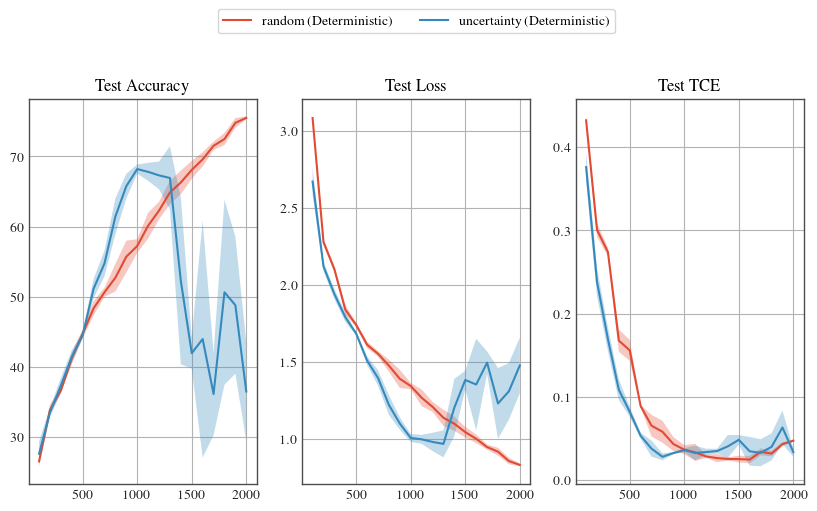

In [11]:
show_std = True
for strat_name, results in tqdm(all_results.items()):

    train_accs = []
    train_loss = []
    test_accs = []
    test_nll = []
    test_tce = []
    n_labeled_samples = []
    for seed_result in results:
        data = seed_result['results']
        # print(strat_name, data['cycle0']['labeled_indices'])

        # Get metric values of interest
        n_labeled_samples.append([data[cycle]['n_labeled_samples'] for cycle in data])
        train_accs.append([data[cycle]['train_history'][-1]['train_acc1'] for cycle in data])
        train_loss.append([data[cycle]['train_history'][-1]['train_loss'] for cycle in data])
        test_accs.append([data[cycle]['test_stats']['test_acc1'] for cycle in data])
        test_nll.append([data[cycle]['test_stats']['test_nll'] for cycle in data])
        test_tce.append([data[cycle]['test_stats']['test_tce'] for cycle in data])

    n_labeled_samples = np.mean(n_labeled_samples, 0)
    train_accs_mean, train_accs_std = np.mean(train_accs, 0), np.std(train_accs, 0)
    train_loss_mean, train_loss_std = np.mean(train_loss, 0), np.std(train_loss, 0)
    test_accs_mean, test_accs_std = np.mean(test_accs, 0), np.std(test_accs, 0)
    test_nll_mean, test_nll_std = np.mean(test_nll, 0), np.std(test_nll, 0)
    test_tce_mean, test_tce_std = np.mean(test_tce, 0), np.std(test_tce, 0)

    plt.subplot(131)
    plt.title('Test Accuracy')
    plt.plot(n_labeled_samples, test_accs_mean, '-', label=strat_name)
    plt.fill_between(n_labeled_samples, test_accs_mean-test_accs_std, test_accs_mean+test_accs_std, alpha=.3)
    plt.subplot(132)
    plt.title('Test Loss')
    plt.plot(n_labeled_samples, test_nll_mean, '-', label=strat_name)
    plt.fill_between(n_labeled_samples, test_nll_mean-test_nll_std, test_nll_mean+test_nll_std, alpha=.3)
    plt.subplot(133)
    plt.title('Test TCE')
    plt.plot(n_labeled_samples, test_tce_mean, '-', label=strat_name)
    plt.fill_between(n_labeled_samples, test_tce_mean-test_tce_std, test_tce_mean+test_tce_std, alpha=.3)

plt.subplot(132).legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=2)
        

### High Budget Domain

#### CIFAR10

In [6]:
dataset = 'CIFAR10'
experiments = {}
# Deterministic
experiments.update({
    'random (Deterministic)': f'results/{dataset}/resnet18/random/N_INIT{1000}__ACQ_SIZE{1000}__N_ACQ{19}/',
    'uncertainty (Deterministic)': f'results/{dataset}/resnet18/uncertainty/N_INIT{1000}__ACQ_SIZE{1000}__N_ACQ{19}/',
    'uncertainty hparams low budget (Deterministic)': f'results/{dataset}/resnet18/uncertainty/N_INIT{1000}__ACQ_SIZE{1000}__N_ACQ{19}_/',
    'badge (Deterministic)': f'results/{dataset}/resnet18/badge/N_INIT{1000}__ACQ_SIZE{1000}__N_ACQ{19}/',
    'coreset (Deterministic)': f'results/{dataset}/resnet18/coreset/N_INIT{1000}__ACQ_SIZE{1000}__N_ACQ{19}/',
    # 'random old hparams (Deterministic)': f'results/{dataset}/resnet18/random/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{9}/',
    # 'uncertainty old hparams (Deterministic)': f'results/{dataset}/resnet18/uncertainty/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{9}/',
})

# MC-Dropout
experiments.update({
    # 'random (MC-Dropout)': f'results/{dataset}/resnet18_mcdropout/random/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{9}/',
    # 'uncertainty (MC-Dropout)': f'results/{dataset}/resnet18_mcdropout/uncertainty/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{9}/',
})

# Ensemble
experiments.update({
    # 'random (Ensemble)': f'results/{dataset}/resnet18_ensemble/random/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{9}/',
    # 'uncertainty (Ensemble)': f'results/{dataset}/resnet18_ensemble/uncertainty/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{9}/',
})

# Eval Model
experiments.update({
    # 'deterministic random queries (Eval Model)': f'results/{dataset}/resnet18/predefined/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{9}/resnet18_random_queries/',
    # 'deterministic uncertainty queries (Eval Model)': f'results/{dataset}/resnet18/predefined/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{9}/resnet18_uncertainty_queries/',
    # 'mcdropout uncertainty queries (Eval Model)': f'results/{dataset}/resnet18/predefined/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{9}/resnet18_mcdropout_uncertainty_queries/',
    # 'ensemble uncertainty queries (Eval Model)': f'results/{dataset}/resnet18/predefined/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{9}/resnet18_ensemble_uncertainty_queries/',
})


all_results = {}
for exp_name, exp_path in tqdm(experiments.items()):
    all_results[exp_name] = get_experiments(Path(exp_path), 'seed*')

 20%|██        | 1/5 [00:01<00:04,  1.14s/it]


AssertionError: No experiments found for results/CIFAR10/resnet18/uncertainty/N_INIT1000__ACQ_SIZE1000__N_ACQ19.

100%|██████████| 3/3 [00:00<00:00, 28.39it/s]


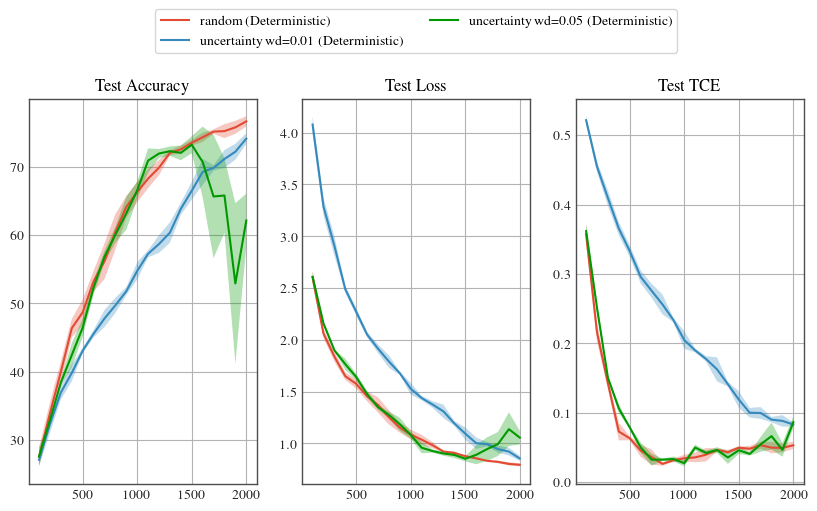

In [8]:
show_std = True
for strat_name, results in tqdm(all_results.items()):

    train_accs = []
    train_loss = []
    test_accs = []
    test_nll = []
    test_tce = []
    n_labeled_samples = []
    for seed_result in results:
        data = seed_result['results']
        # print(strat_name, data['cycle0']['labeled_indices'])

        # Get metric values of interest
        n_labeled_samples.append([data[cycle]['n_labeled_samples'] for cycle in data])
        train_accs.append([data[cycle]['train_history'][-1]['train_acc1'] for cycle in data])
        train_loss.append([data[cycle]['train_history'][-1]['train_loss'] for cycle in data])
        test_accs.append([data[cycle]['test_stats']['test_acc1'] for cycle in data])
        test_nll.append([data[cycle]['test_stats']['test_nll'] for cycle in data])
        test_tce.append([data[cycle]['test_stats']['test_tce'] for cycle in data])

    n_labeled_samples = np.mean(n_labeled_samples, 0)
    train_accs_mean, train_accs_std = np.mean(train_accs, 0), np.std(train_accs, 0)
    train_loss_mean, train_loss_std = np.mean(train_loss, 0), np.std(train_loss, 0)
    test_accs_mean, test_accs_std = np.mean(test_accs, 0), np.std(test_accs, 0)
    test_nll_mean, test_nll_std = np.mean(test_nll, 0), np.std(test_nll, 0)
    test_tce_mean, test_tce_std = np.mean(test_tce, 0), np.std(test_tce, 0)

    plt.subplot(131)
    plt.title('Test Accuracy')
    plt.plot(n_labeled_samples, test_accs_mean, '-', label=strat_name)
    if show_std:
        plt.fill_between(n_labeled_samples, test_accs_mean-test_accs_std, test_accs_mean+test_accs_std, alpha=.3)
    plt.subplot(132)
    plt.title('Test Loss')
    plt.plot(n_labeled_samples, test_nll_mean, '-', label=strat_name)
    if show_std:
        plt.fill_between(n_labeled_samples, test_nll_mean-test_nll_std, test_nll_mean+test_nll_std, alpha=.3)
    plt.subplot(133)
    plt.title('Test TCE')
    plt.plot(n_labeled_samples, test_tce_mean, '-', label=strat_name)
    if show_std:
        plt.fill_between(n_labeled_samples, test_tce_mean-test_tce_std, test_tce_mean+test_tce_std, alpha=.3)

plt.subplot(132).legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=2)
        